## Imports

In [247]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("../data/01_raw/en.openfoodfacts.org.products.tsv", sep="\t", low_memory=False)



## Quelques infos sur la DataFrame

In [248]:
print("Taille de la table : {} lignes et {} colonnes.".format(
    df.shape[0], df.shape[1])
)
df.sample(3)

Taille de la table : 356027 lignes et 163 colonnes.


,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
124703,0669212176066,http://world-en.openfoodfacts.org/product/0669...,usda-ndb-import,1489091274,2017-03-09T20:27:54Z,1489091274,2017-03-09T20:27:54Z,Okra,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-6.0,-6.0,NaN,NaN
16424,0020685079405,http://world-en.openfoodfacts.org/product/0020...,usda-ndb-import,1489059805,2017-03-09T11:43:25Z,1489059805,2017-03-09T11:43:25Z,Cooked Potato Chips,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,8.0,8.0,NaN,NaN
101304,0080364255032,http://world-en.openfoodfacts.org/product/0080...,usda-ndb-import,1489143350,2017-03-10T10:55:50Z,1489143350,2017-03-10T10:55:50Z,"American Finest, Sandwich Slices",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN


## Visualisation du pourcentage de valeurs manquantes

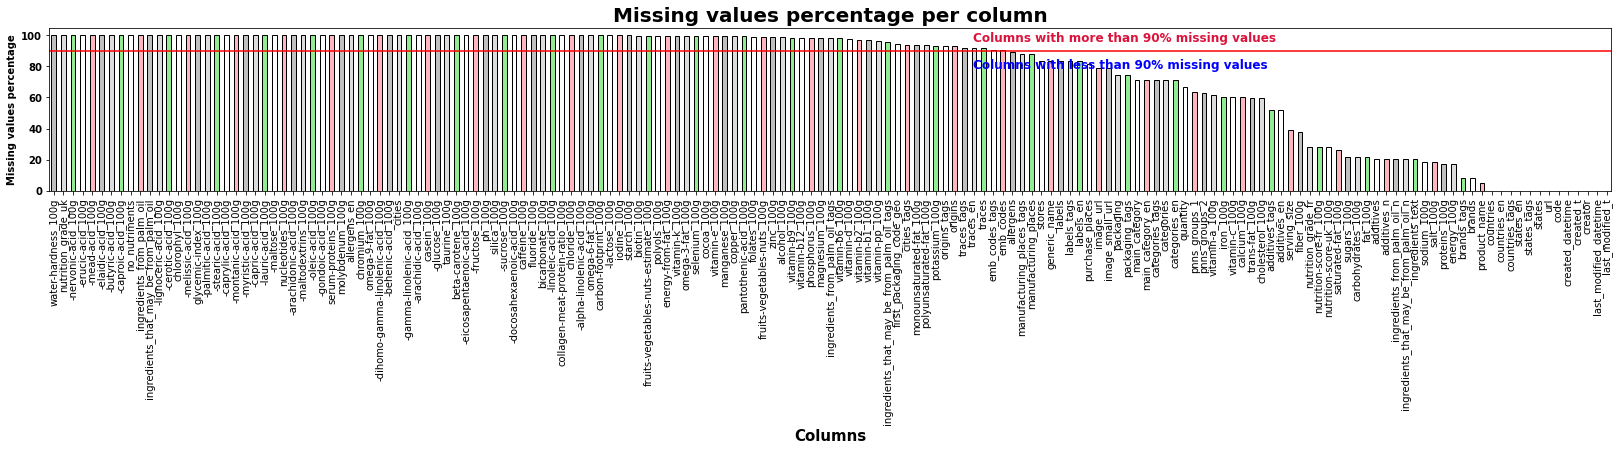

In [249]:
def msv1(data, thresh=20, color='black', edgecolor='black', width=15, height=3):

    plt.figure(figsize=(width,height))
    percentage=(data.isnull().mean())*100
    percentage.sort_values(ascending=False).plot.bar(color=color, edgecolor=edgecolor)
    plt.axhline(y=thresh, color='r', linestyle='-')
    plt.title('Missing values percentage per column', fontsize=20, weight='bold' )
    plt.text(len(data.isnull().sum()/len(data))/1.7, thresh+12.5, 'Columns with more than %s%s missing values' %(thresh, '%'), fontsize=12,weight='bold', color='crimson',
         ha='left' ,va='top')
    plt.text(len(data.isnull().sum()/len(data))/1.7, thresh - 5, 'Columns with less than %s%s missing values' %(thresh, '%'), fontsize=12,weight='bold', color='blue',
         ha='left' ,va='top')
    plt.xlabel('Columns', size=15, weight='bold')
    plt.ylabel('Missing values percentage', weight='bold')
    plt.yticks(weight ='bold')
    
    return plt.show()

msv1(df,90, color=('silver', 'gainsboro', 'lightgreen', 'white', 'lightpink'), width=28, height=3)


## Sélection des entrées concernant uniquement en France

In [250]:
# Vérification de la consistence des données de "countries"
print(df["countries"].value_counts())
print("Plusieurs termes sont utilisés pour définir la France")

# Uniformisation des lignes concernant la France
df["countries"].str.replace(r".*(fr).*", "France", case=False, regex=True)

# Réduction du DataFrame à la France
df = df[df["countries"] == "France"]

US                                                                                                                                                       169789
France                                                                                                                                                   106296
en:FR                                                                                                                                                     16056
Suisse                                                                                                                                                    12003
Deutschland                                                                                                                                                6900
                                                                                                                                                          ...  
France,Belgique,Grèce,Pays-Bas,Espagne  

## Retrait des lignes sans nom de produit

In [251]:
print(df.product_name.isna().value_counts())
df = df[df.product_name.notna()]

False    105094
True       1202
Name: product_name, dtype: int64


## Sélection des colonnes pertinentes

In [252]:
df = df[
    [
        'product_name',
        'brands',
        'categories',
        'ingredients_text',
        'allergens',
        'nutrition_grade_fr',
        'energy_100g',
        'fat_100g',
        'saturated-fat_100g',
        'carbohydrates_100g',
        'sugars_100g',
        'fiber_100g',
        'proteins_100g',
        'salt_100g'
    ]
]

## Recherche et suppression de doublons

In [253]:
print(df.duplicated().value_counts())
df.drop_duplicates(inplace=True)

False    104932
True        162
dtype: int64


## Recherche de données abérantes en ce qui concerne les valeurs énergétiques et traitement de ces données

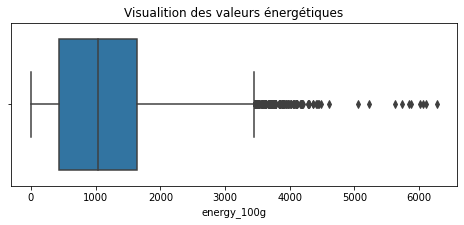

In [254]:
plt.figure(figsize=(8,3))
plt.title("Visualition des valeurs énergétiques")
ax = sns.boxplot(x = df['energy_100g'])

# La valeur énergétique maximale que l'on peut atteindre est d'environ 3700 Kj
df= df[df["energy_100g"] <= 3700]   

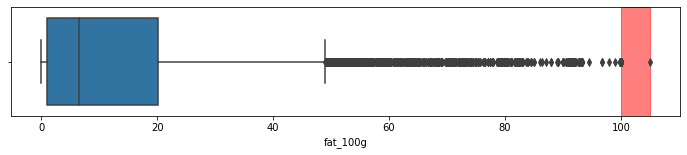

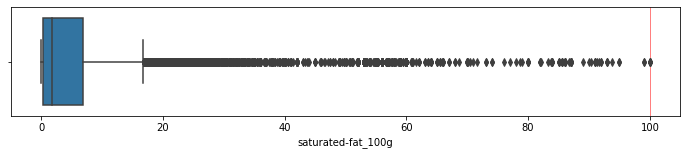

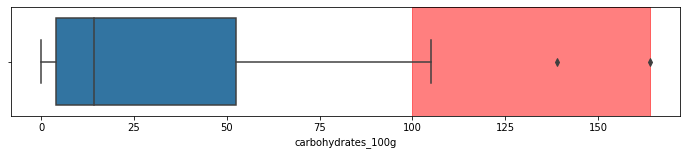

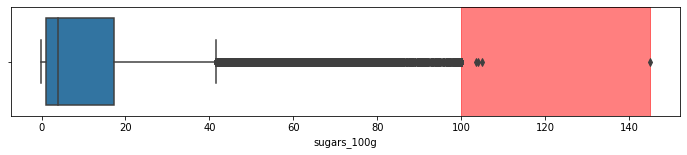

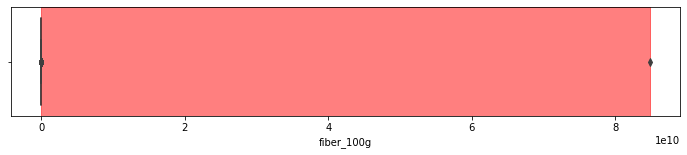

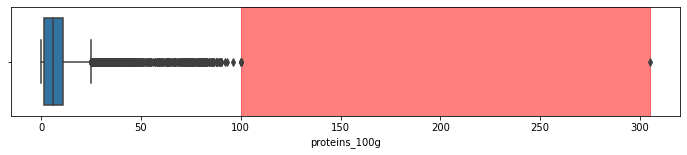

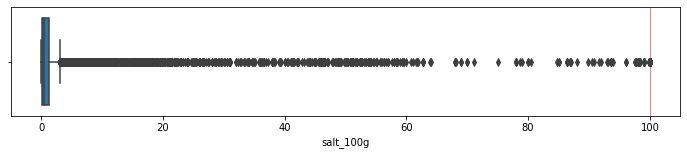

In [255]:
temp_df = df[[
    'fat_100g',
    'saturated-fat_100g',
    'carbohydrates_100g',
    'sugars_100g',
    'fiber_100g',
    'proteins_100g',
    'salt_100g',
]]


for i, col in enumerate(temp_df.columns):
    xmax = df[col].max()
    if xmax <= 100:
        xmax = 100
    plt.figure(i, figsize=(12,2))
    plt.axvspan(100,df[col].max(), color='red', alpha=0.5)
    sns.boxplot(x=col, data=temp_df)

## Retrait des valeurs abérantes ( au delà de 100g / 100g)

In [256]:
for col in temp_df:
    df = df[df[col] <= 100]


## Vérification après retrait des valeurs

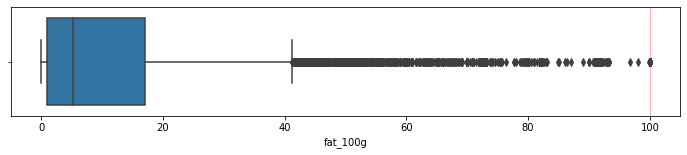

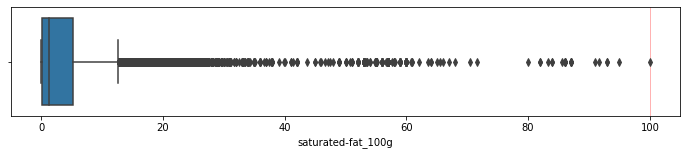

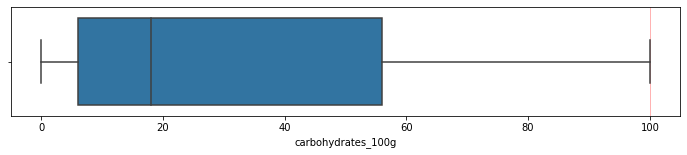

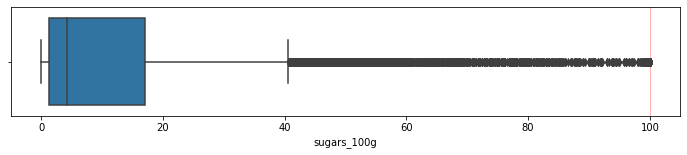

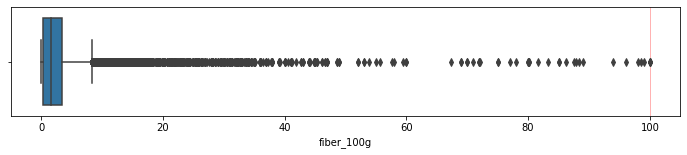

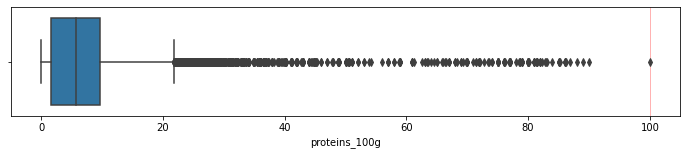

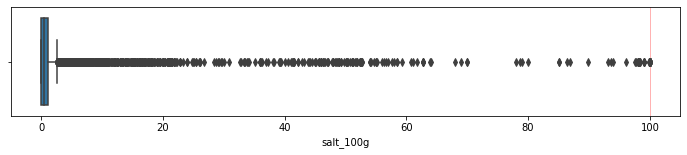

In [257]:
temp_df = df[[
    'fat_100g',
    'saturated-fat_100g',
    'carbohydrates_100g',
    'sugars_100g',
    'fiber_100g',
    'proteins_100g',
    'salt_100g',
]]

for i, col in enumerate(temp_df.columns):    
    xmax = df[col].max()
    if xmax <= 100:
        xmax = 100
    plt.figure(i, figsize=(12,2))
    plt.axvspan(100, xmax, color='red', alpha=0.3)
    sns.boxplot(x=col, data=temp_df)

In [258]:
## Traitement des valeurs manquantes

In [259]:
cols =  [
    'energy_100g',
    'fat_100g',
    'saturated-fat_100g',
    'carbohydrates_100g',
    'sugars_100g',
    'fiber_100g',
    'proteins_100g',
    'salt_100g',
]
for col in cols:
    df_2[col].fillna(0.0, inplace=True)
    
cols2 = [
    "categories",
    "ingredients_text",
    "allergens",
    "nutrition_grade_fr",
    "brands"
]
for col in cols2:
    df_2[col].fillna("Non renseigné", inplace=True)

## visualisation finale avec missingno

<AxesSubplot:>

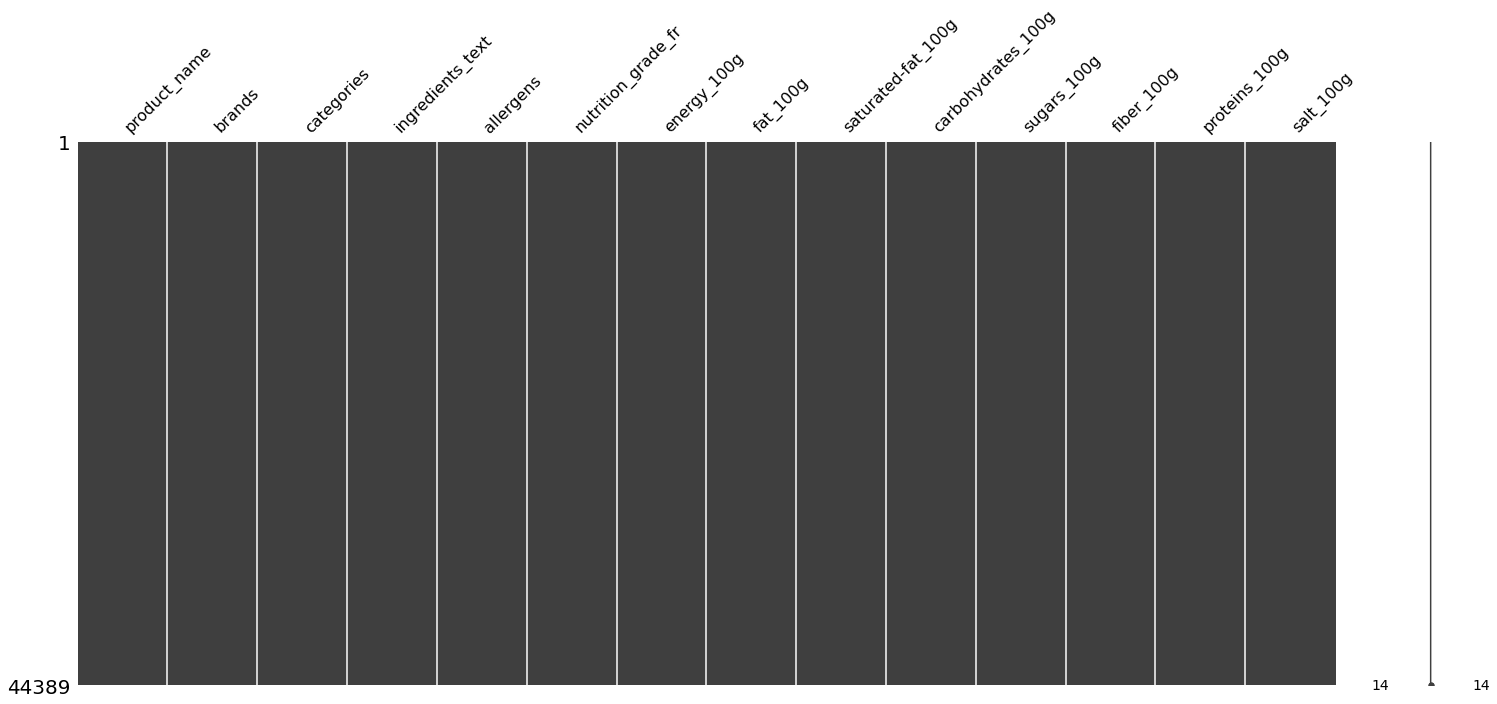

In [260]:
msno.matrix(df_2)